# Lin-Kernighan algorithm to solve TSP
Apply TSP to abstract it in the context of Baja California:

Tijuana, Mexicali, Ensenada, Tecate, Rosarito, San Quintin, San Felipe

In [112]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [113]:
costs_df = pd.read_csv('bc_tsp_matrix.csv', index_col=0)
costs = costs_df.values.tolist()

In [114]:
def tour_cost(tour):
    return sum(costs[tour[i]][tour[(i+1) % len(tour)]] for i in range(len(tour)))


In [115]:
def show_tsp_path(G, tsp_path, title="TSP Path Visualization"):
    plt.figure(figsize=(7, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, edge_color='gray')
    
    tsp_edges = [(tsp_path[i], tsp_path[i+1]) for i in range(len(tsp_path)-1)]
    if len(tsp_path) > 1:
        tsp_edges.append((tsp_path[-1], tsp_path[0]))
    nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, width=3, alpha=0.8, edge_color='red', arrows=True, arrowsize=20)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    tsp_edge_labels = {}
    for edge in tsp_edges:
        if G.has_edge(edge[0], edge[1]):
            tsp_edge_labels[edge] = G[edge[0]][edge[1]]['weight']
    
    nx.draw_networkx_edge_labels(G, pos, tsp_edge_labels, font_size=9, font_color='red', font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [116]:
def LKH(costs, initial_tour, max_iter=50, max_depth=3, dont_look_patience=2):
    n = len(costs)
    tour = initial_tour[:]
    best_tour = tour[:]
    best_cost = tour_cost(tour)
    no_improve_count = 0

    dont_look = [0] * n

    def get_2opt_moves(current_tour):
        moves = []
        for i in range(n - 1):
            if dont_look[i] >= dont_look_patience:
                continue
            for j in range(i + 2, n):
                a, b = current_tour[i], current_tour[i + 1]
                c, d = current_tour[j], current_tour[(j + 1) % n]
                gain = (costs[a][b] + costs[c][d]) - (costs[a][c] + costs[b][d])
                if gain > 0:
                    moves.append((i, j, gain))
        return sorted(moves, key=lambda x: x[2], reverse=True)  # Mejores primero

    def apply_2opt(current_tour, i, j):
        new_tour = current_tour[:]
        new_tour[i + 1:j + 1] = reversed(new_tour[i + 1:j + 1])
        return new_tour

    def backtrack_search(current_tour, depth=0, accumulated_gain=0):
        if depth >= max_depth:
            return None, accumulated_gain

        moves = get_2opt_moves(current_tour)

        for i, j, gain in moves[:5]:
            new_tour = apply_2opt(current_tour, i, j)
            new_gain = accumulated_gain + gain

            result_tour, total_gain = backtrack_search(new_tour, depth + 1, new_gain)

            if result_tour is not None and total_gain > 0:
                return result_tour, total_gain

            if new_gain > 0:
                return new_tour, new_gain

        return None, accumulated_gain

    while no_improve_count < max_iter:
        improved_tour, total_gain = backtrack_search(tour)

        if improved_tour is not None:
            tour = improved_tour
            dont_look = [0] * n
            no_improve_count = 0

            current_cost = tour_cost(tour)
            best_cost = current_cost
            best_tour = tour[:]
        else:
            dont_look = [d + 1 for d in dont_look]
            no_improve_count += 1

    return best_tour, best_cost

In [117]:
import time

print("=" * 70)
print(" === LKH === ")
print("=" * 70)

initial_tour = [0, 1, 2, 3, 4, 5, 6]
initial_cost = tour_cost(initial_tour)

print(f"\n Ruta inicial: {' -> '.join(str(city) for city in initial_tour)}")
print(f" Costo inicial: {initial_cost/60:.2f} hrs\n")

start = time.time()
final_tour, final_cost = LKH(costs, initial_tour)
time_lkh = time.time() - start

print(f" Ruta final: {' -> '.join(str(city) for city in final_tour)}")
print(f" Costo final: {final_cost/60:.2f} hrs")
print(f" Tiempo: {time_lkh:.6f} segundos")

 === LKH === 

 Ruta inicial: 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6
 Costo inicial: 22.95 hrs

 Ruta final: 0 -> 3 -> 1 -> 6 -> 5 -> 2 -> 4
 Costo final: 15.27 hrs
 Tiempo: 0.000178 segundos


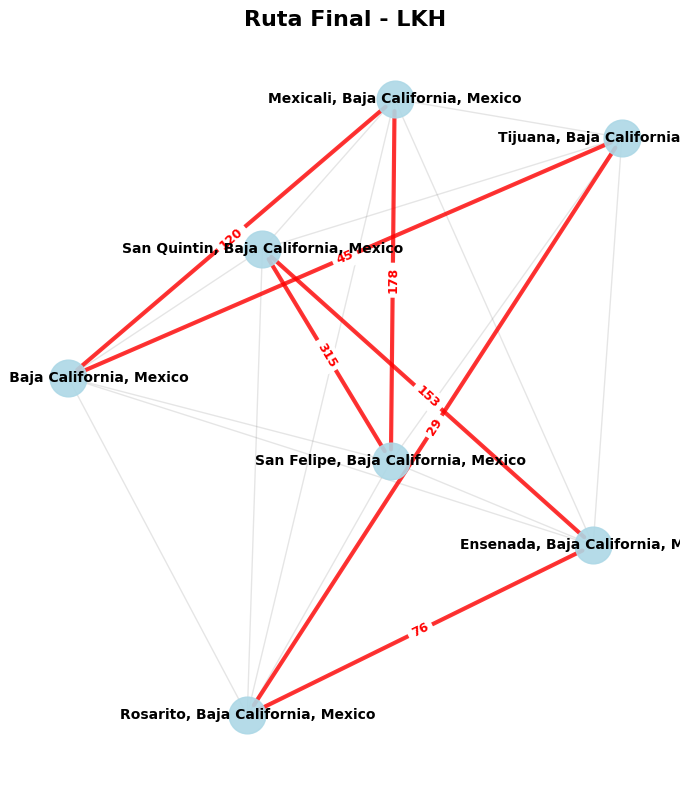

In [118]:
G = nx.Graph()
for city1 in costs_df.index:
    for city2 in costs_df.columns:
        if city1 != city2:
            tiempo = costs_df.loc[city1, city2]
            G.add_edge(city1, city2, weight=tiempo)

# Agregar camino al nodo inicial para cerrar el ciclo
G.add_edge(costs_df.index[final_tour[-1]], costs_df.index[final_tour[0]], weight=costs_df.loc[costs_df.index[final_tour[-1]], costs_df.columns[final_tour[0]]])

city_names = costs_df.index.tolist()
final_tour_names = [city_names[i] for i in final_tour]

show_tsp_path(G, final_tour_names, title="Ruta Final - LKH")